In [1]:
import os
import cv2
import sys
import torch 
import torchvision 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

c:\Users\parigoel\Anaconda3\envs\greentrackenv\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


PyTorch version: 2.4.1
Torchvision version: 0.19.1
CUDA is available: False


#### https://www.kaggle.com/code/yogendrayatnalkar/sam-automatic-semantic-segmentation

In [2]:
# SAM initial model loading
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

c:\Users\parigoel\Anaconda3\envs\greentrackenv\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.9]])
        img[m] = color_mask
    ax.imshow(img)

IMG shape:  (1024, 1024, 3)


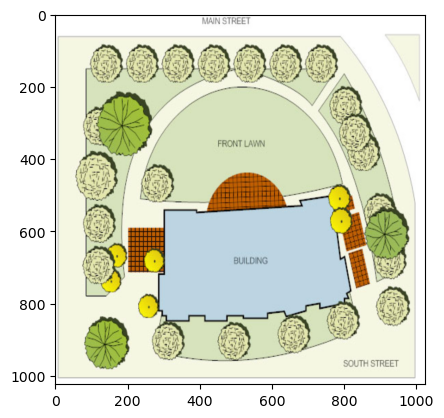

In [4]:
img_path = "../data/landscape_plans/landscape3.jpg"
img = cv2.imread(img_path)

# resizing the image to 1024x1024
img = cv2.resize(img, (1024, 1024))
print("IMG shape: ", img.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [16]:
# Automatic Mask Generator

# mask_generator = SamAutomaticMaskGenerator(
#     model=sam,
#     points_per_side=51,
#     pred_iou_thresh=0.86,
#     stability_score_thresh=0.92,
#     crop_n_layers=1,
#     crop_n_points_downscale_factor=2,
#     min_mask_region_area=100,  # Requires open-cv to run post-processing
# )

mask_generator = SamAutomaticMaskGenerator(model=sam)

Number of masks:  61
Shape of individual mask:  (1024, 1024)


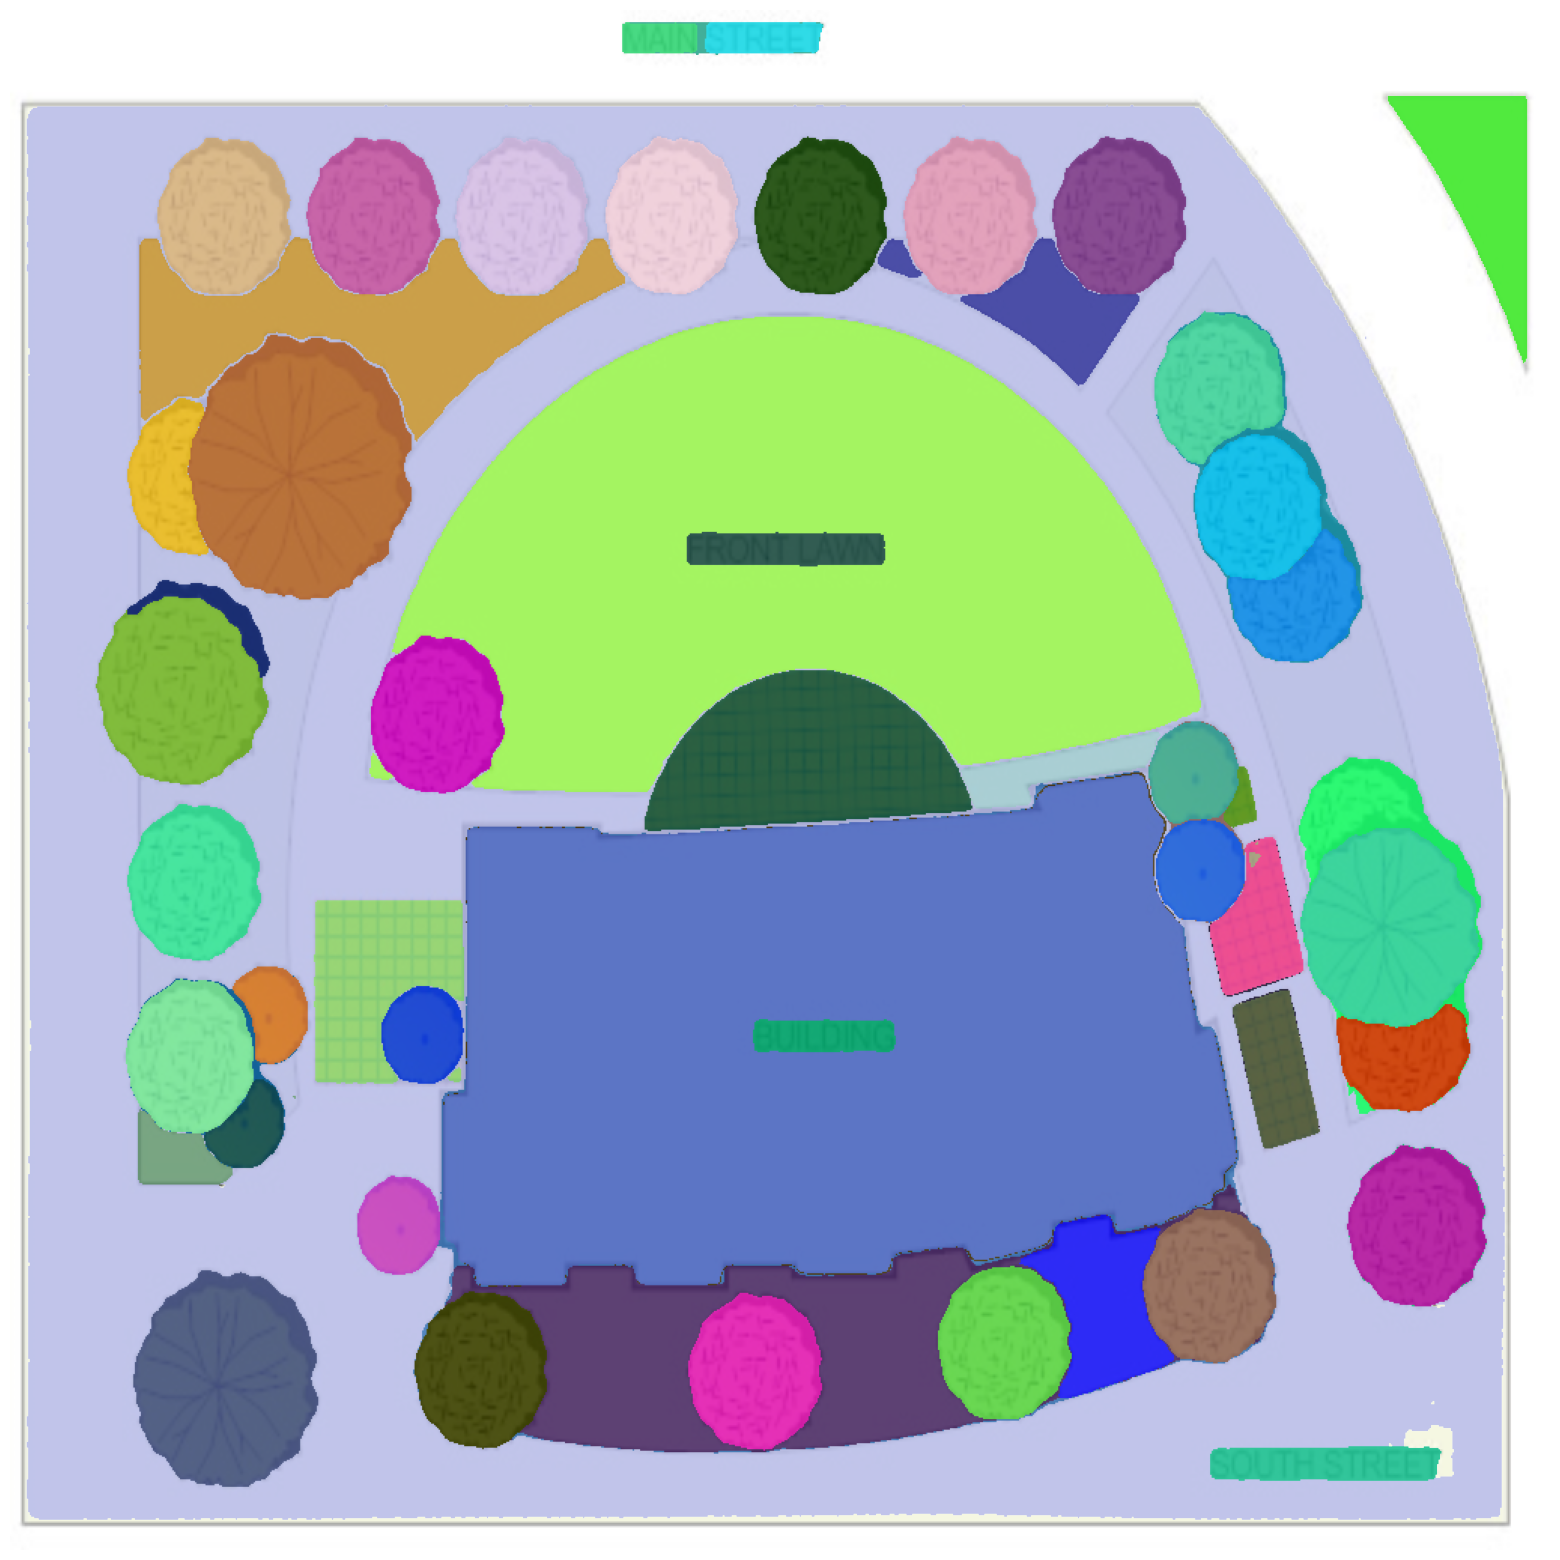

In [17]:
# Generate mask using automatic-mask-generator
masks = mask_generator.generate(img_rgb)
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
print("Number of masks: ", len(masks))
print("Shape of individual mask: ",masks[0]['segmentation'].shape)

plt.figure(figsize=(20,20))
plt.imshow(img_rgb)
show_anns(masks)
plt.axis('off')
plt.show() 

In [18]:
# Get the encoder embeddings
mask_generator.predictor.set_image(img_rgb)
enc_emb = mask_generator.predictor.features
enc_emb = enc_emb.to("cpu").numpy()
enc_emb = enc_emb[0].transpose((1,2,0))

print("Encoder Embeddings Shape: ", enc_emb.shape)


Encoder Embeddings Shape:  (64, 64, 256)


In [19]:
# Get Mask Embedding for each segment
# Mask Embedding = Average of patch embeddings corresponding to individual segment
# There are 61 masks created using Automatic-Mask-Generator
# The output shape of encoder is: 256x64x64 -> which means its a 64x64 image with 256 channels
# For each mask, get all the corresponding patch embeddings
# The average of all patch-embeddings for a given mask will be termed as "Mask Embedding"

def get_mask_embedding_using_patch_embeddings(mask, enc_emb, return_all = False):
    # Converting mask of shape 1024x1024 to shape: 64x64x16x16 
    # This assumes that patch size is 16x16 becuase what we mainly need is: 64x64 at the start
    # We are free to change the patch-size accordingly
    split_mask = np.array(np.split(mask, 64, axis = -1))
    split_mask = np.array(np.split(split_mask, 64, axis = -2))
    split_mask = split_mask*1 # split_mask is a mask of shape: 64x64x16x16 
    # split_mask is binary (have value of 0 or 1 not between)
    
    # Converting split_mask of shape: 64x64x16x16 to 64x64 
    # by adding all numbers in every 16x16 grid
    split_mask = np.sum(split_mask, axis = -1)
    split_mask = np.sum(split_mask, axis = -1)
    
    # Get all patch embeddings from this split_mask of 64x64
    # In this split_mask, at all locations where the cell-value is greater than 1,
    # It means that we need to pick the patch-embeddding at this given index (X,Y) value
    patch_locations = np.where(split_mask > 1)
    n_patch_embeddings = enc_emb[patch_locations]
    mask_embedding = n_patch_embeddings.mean(axis = 0, keepdims = False)
    
    if return_all:
        return mask_embedding, patch_locations, n_patch_embeddings
    return mask_embedding

In [23]:
masks_embeddings_li = []
for i in range(len(masks)):
    nth_mask = masks[i]['segmentation']
    nth_mask_emb = get_mask_embedding_using_patch_embeddings(nth_mask, enc_emb)
    masks_embeddings_li.append(nth_mask_emb)
    
masks_embeddings_arr = np.array(masks_embeddings_li)
print("Mask Embedding shape: ", masks_embeddings_arr.shape)
print(masks_embeddings_arr[0])

Mask Embedding shape:  (61, 256)
[ 4.91386056e-02 -4.45850678e-02 -5.15221171e-02 -7.23219896e-03
 -3.17310356e-02 -2.14321297e-02 -3.05229612e-02  1.03703514e-02
  1.00468611e-03 -3.02694067e-02  1.68763790e-02 -1.33965880e-01
  2.31151227e-02 -1.70821715e-02 -4.35284786e-02  1.70978680e-02
 -6.30362108e-02  2.28496753e-02  1.09137334e-01 -1.12894966e-04
  9.70018581e-02  9.96007547e-02 -4.51317616e-03 -1.13311987e-02
  4.63373028e-03 -2.18667477e-01  5.32066624e-04  1.48589639e-02
  2.24287044e-02 -3.21082734e-02 -3.93586867e-02  2.05899626e-01
 -5.28444489e-03 -8.30210373e-03 -2.83848727e-03 -2.44486928e-02
 -3.58609706e-02  2.23025344e-02 -3.58020179e-02 -4.14300598e-02
  5.68615913e-04  4.09021750e-02 -3.29654478e-03  3.67723629e-02
  2.26547364e-02  1.50911398e-02 -4.32048365e-03  6.78601966e-04
  4.67750942e-03 -4.02778061e-03  5.53375557e-02  5.06258048e-02
 -1.08569972e-01  4.04199511e-02 -1.29500944e-02  3.14799771e-02
 -1.04284855e-02 -1.42524811e-02  4.94384812e-03  1.36226

In [48]:
# Clustering using DB Scan
clustering = DBSCAN(
    eps=0.09,
    min_samples=8,
    metric="cosine"
).fit(masks_embeddings_arr)

print("Clustering Labels: ", np.unique(clustering.labels_))

Clustering Labels:  [-1  0]


Number of items in cluster 0:  (9,)


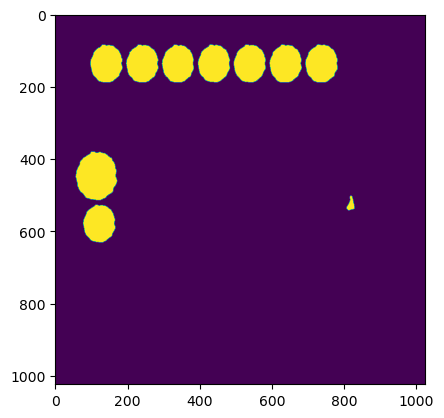

In [49]:
# Label 0 Semantic Mask
label_0 = np.where(clustering.labels_ == 0)
print("Number of items in cluster 0: ", label_0[0].shape)

lbl0_semantic_seg_mask = masks[-1]['segmentation']*1
for seg_no in label_0[0]:
    lbl0_semantic_seg_mask += masks[seg_no]['segmentation']*1

# Plottign the label 0 semantic mask
plt.imshow(lbl0_semantic_seg_mask)

In [42]:
# Final Output
binary_ind = np.where(lbl0_semantic_seg_mask > 0)
mask = lbl0_semantic_seg_mask.copy()
mask[binary_ind] = 1

img_mask = img_rgb.copy()
img_mask[:,:,0] = img_mask[:,:,0]*mask
img_mask[:,:,1] = img_mask[:,:,1]*mask
img_mask[:,:,2] = img_mask[:,:,2]*mask

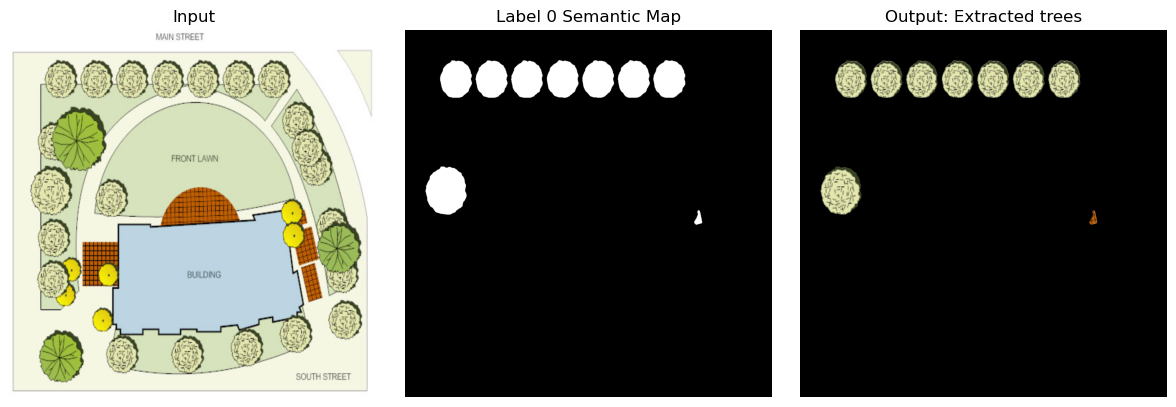

In [44]:
# Create a figure and three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the first image on the first subplot
axes[0].imshow(img_rgb, cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')  # Hide axes

# Plot the second image on the second subplot
axes[1].imshow(lbl0_semantic_seg_mask, cmap='gray')
axes[1].set_title('Label 0 Semantic Map')
axes[1].axis('off')  # Hide axes

# Plot the third image on the third subplot
axes[2].imshow(img_mask, cmap='gray')
axes[2].set_title('Output: Extracted trees')
axes[2].axis('off')  # Hide axes

# Adjust layout and display the plot
plt.tight_layout()
plt.show()